In [1]:
import pandas as pd
import os
import sys
import re
import seaborn as sns
import matplotlib.pyplot as plt
import shap


In [2]:
from xgboost import XGBRegressor


In [3]:
afcar_2021 =pd.read_table('./Data/AFCARS_Data/FC2021v1.tab')

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
afcar_2021['DISREASN'].value_counts()

99    391094
1     100772
3      53771
5      25150
4      19599
2      12540
6       2327
7        562
8        372
Name: DISREASN, dtype: int64

In [5]:
afcar_2021.RecNumbr.nunique()

606180

In [6]:
adopted_or_still_in_fc = afcar_2021[afcar_2021.DISREASN.isin([3,99])]

In [7]:
req_cols = ['LifeLOS','WHITE','STATE','CHBEHPRB','CLINDIS','EVERADPT','XIXMEDCD','TOTALREM','SEX','AMIAKN','ASIAN','BLKAFRAM','HAWAIIPI','UNTODETM','HISORGIN','MR','VISHEAR','PHYDIS'
           ,'EmotDist','OTHERMED','AGEADOPT','MANREM','PHYABUSE','SEXABUSE','NEGLECT','AAPARENT','DAPARENT',
           'AACHILD','DACHILD','CHILDIS','PRTSDIED','PRTSJAIL','NOCOPE','ABANDMNT','RELINQSH','HOUSING','IVEFC',
           'IVAAFDC','SSIOTHER','NOA','RU13','DISREASN']#'IVEAA',

In [8]:
req_df = adopted_or_still_in_fc[req_cols]

In [9]:
val = req_df['DISREASN'].apply(lambda p:int(p==3))
req_df.loc[:,'IS_ADOPTED'] = val


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
req_df = req_df.drop(columns={'DISREASN'})

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [12]:
def plot_feature_importance(importance,names,model_type):

        #Create arrays from feature importance and feature names
        feature_importance = np.array(importance)
        feature_names = np.array(names)

        #Create a DataFrame using a Dictionary
        data={'feature_names':feature_names,'feature_importance':feature_importance}
        fi_df = pd.DataFrame(data)

        #Sort the DataFrame in order decreasing feature importance
        fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
        
        fi_df = fi_df.iloc[:9,:]
        #Define size of bar plot
        plt.figure(figsize=(10,8))
        #Plot Searborn bar chart
        sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
        #Add chart labels
        plt.title(model_type + 'FEATURE IMPORTANCE')
        plt.xlabel('FEATURE IMPORTANCE')
        plt.ylabel('FEATURE NAMES')

In [13]:
req_df = req_df.dropna()

In [14]:
req_df.dropna()['IS_ADOPTED'].value_counts()

0    277445
1     43293
Name: IS_ADOPTED, dtype: int64

In [15]:
X = req_df.drop(columns={'IS_ADOPTED'})
y = req_df['IS_ADOPTED']

In [16]:
import numpy as np
from sklearn.utils import resample

X_oversampled, y_oversampled = resample(X[y == 0],y[y == 0],replace=False,n_samples=X[y == 1].shape[0],random_state=123)
X_balanced = np.vstack((X[y == 1], X_oversampled))
y_balanced = np.hstack((y[y == 1], y_oversampled))


In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=1) # 70% training and 30% test

# Xgboost

In [18]:
req_cols_dict = {'LifeLOS':'Total days in FC','STATE':'State','XIXMEDCD':'Medicaid Eligible','EVERADPT':'Adopted before','TOTALREM':'Number of Removals',
           'WHITE':'White','CHBEHPRB':'Behavioral Problem','CLINDIS':'Clinical Disability','MANREM':'Manner of Removal','DAPARENT':'Drug Addicted Parent'}

In [19]:
first_cols = list(req_cols_dict.values())

In [20]:
X_test = pd.DataFrame(X_test)

X_test.columns = X.columns

X_test = X_test.rename(columns=req_cols_dict)

In [21]:
from xgboost import XGBClassifier

In [22]:
xgb = XGBClassifier(n_estimators=50,random_state=123)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

In [23]:
y_pred = xgb.predict(X_test)

In [24]:
metrics.f1_score(y_pred=y_pred,y_true=y_test)

0.8153130590339892

In [25]:
metrics.roc_auc_score(y_score=y_pred,y_true=y_test)

0.8008100248642483

In [26]:
metrics.confusion_matrix(y_pred=y_pred,y_true=y_test)

array([[ 9420,  3482],
       [ 1680, 11394]], dtype=int64)

In [27]:
metrics.precision_score(y_pred=y_pred,y_true=y_test)

0.765931702070449

In [28]:
metrics.recall_score(y_pred=y_pred,y_true=y_test)

0.8715006883891694

In [29]:
xgb.feature_importances_

array([0.1025176 , 0.04609451, 0.04017127, 0.08581102, 0.02850567,
       0.05879482, 0.05926251, 0.06990267, 0.00467169, 0.0076565 ,
       0.00750073, 0.00590713, 0.00773648, 0.00610916, 0.01331143,
       0.00906506, 0.00935085, 0.00723853, 0.01609172, 0.01365426,
       0.02819624, 0.06880392, 0.01093063, 0.0127922 , 0.01272119,
       0.00597378, 0.04372752, 0.00588017, 0.01109388, 0.01063195,
       0.01220768, 0.00791471, 0.00656938, 0.00742392, 0.01311092,
       0.00705989, 0.02813865, 0.03428605, 0.02730242, 0.03414014,
       0.01174112], dtype=float32)

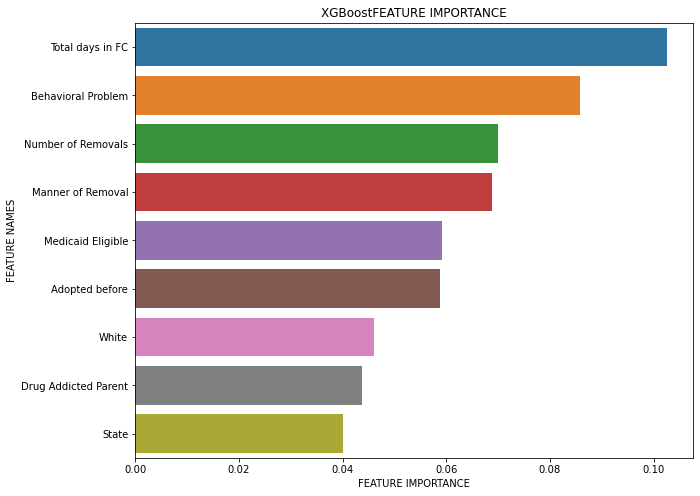

In [30]:
plot_feature_importance(xgb.feature_importances_,X_test.columns,'XGBoost')

In [31]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [32]:
# shap.summary_plot??

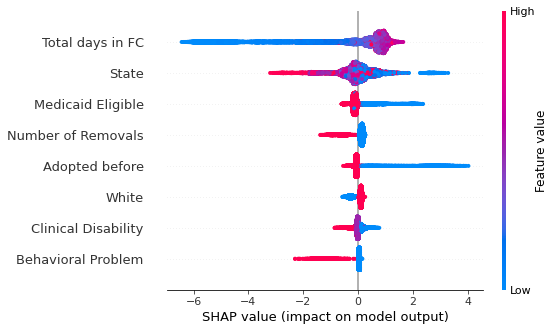

In [33]:
shap.summary_plot(shap_values[:,:len(req_cols_dict)-2], X_test.iloc[:,:len(req_cols_dict)-2])


# EDA of Important Variables

In [34]:
life_os = req_df[['LifeLOS','IS_ADOPTED']]

In [35]:
req_df[['LifeLOS','IS_ADOPTED']].groupby('IS_ADOPTED').mean()

,LifeLOS
IS_ADOPTED,
0,758.435038
1,1093.773959


In [36]:
life_os.LifeLOS.max()

7590.0

In [37]:
num_bins = 20
bins = [i*365 for i in range(num_bins)]
labels = [i for i in range(1,num_bins)]
life_os['binned'] = pd.cut(life_os['LifeLOS'], bins=bins, labels=labels)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
p = life_os.groupby('binned').mean()['IS_ADOPTED']

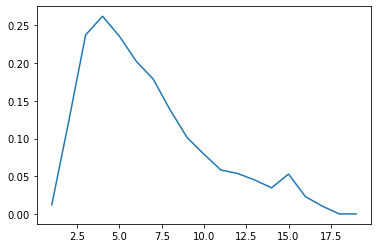

In [39]:

plt.plot(p)